In [20]:
import os

datadir = os.path.join('data')
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')

In [21]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    columns_to_drop.extend(ds.filter(regex='.*/tool').columns)
    columns_to_drop.extend(ds.filter(regex='.*/tool/spm').columns)
    ds = ds.drop(columns=columns_to_drop)
    return ds

In [22]:
import pandas as pd

correlations = pd.read_csv(corr_path, delimiter=';')
correlations = correlations.rename(columns={"correlation": "spearman"})

print(f"{len(correlations)} correlations in matrix")

1004003 correlations in matrix


In [23]:
dataset = pd.read_csv(ds_path, delimiter=';')
dataset = dataset.rename(columns={"from_mean": "spearman_from_mean", "from_ref": "spearman_from_ref"})

# add ref config to dataset
ref_config = pd.read_csv('/home/ymerel/fmri/OHBM_2026_neurovariants/data/expert_config.csv', delimiter=';')  # Adjust delimiter if needed
ref_config['id'] = 'ref'
ref_config[f'spearman_from_ref'] = 1.0
ref_config[f'spearman_from_mean'] = correlations[
    (correlations['source'] == 'mean') &
    (correlations['target'] == 'ref')
]['spearman'].values[0]
dataset = pd.concat([dataset, ref_config], axis=0, ignore_index=True)

normalized_dataset = normalize_dataset(dataset)

print(f"{len(normalized_dataset)} configs in dataset")

normalized_dataset.to_csv(os.path.join(datadir, f'normalized_dataset.csv'), index=False, sep=';')

normalized_dataset.head(1010)

1001 configs in dataset


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,spatial_normalization/template/MNI305,spatial_normalization/bias_fwhm,spatial_normalization/bias_regularisation/very_light,coregistration/source_target/anat_on_func,slice_timing_correction/ref_slice/first,spatial_normalization/interpolation/nearest_neighbour,signal_modeling/hrf/canonical,id,spearman_from_ref,spearman_from_mean
0,False,True,True,False,False,False,False,False,False,0,...,False,0,0,True,False,True,False,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0.467386,0.533488
1,True,False,False,False,True,False,True,False,False,0,...,False,0,0,False,False,False,False,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,0.624349,0.671276
2,True,True,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,3097a7dc41788499cf25575641e12f92017eaec464039b...,0.054786,0.26594
3,False,True,False,False,False,False,False,False,False,0,...,False,0,0,True,True,True,False,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,0.455374,0.584125
4,True,True,False,False,True,False,False,False,False,0,...,False,0,0,False,False,False,False,63bea197905677a189c165af71c8fc3933529cfb732832...,0.054786,0.26594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,False,False,False,False,False,False,False,False,False,0,...,False,0,0,False,True,False,False,91801a03dc14fd0a3028e8181828cd0d92bd12b830c86f...,0.123223,0.368549
997,False,False,False,False,True,False,False,False,False,0,...,False,0,0,True,False,True,False,ffcb718b2eaf9394c568665e65cb40e5b070ae63c2dd91...,0.070953,0.282691
998,False,False,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,c870f6446e080d90673cfac597ca16e081ea1b510ce78c...,0.138238,0.392617
999,True,True,False,False,True,False,True,False,False,0,...,False,0,0,True,False,False,False,315c85bdd9845ee4f5d15e689759ac1971849341a8b9b8...,0.588806,0.661417


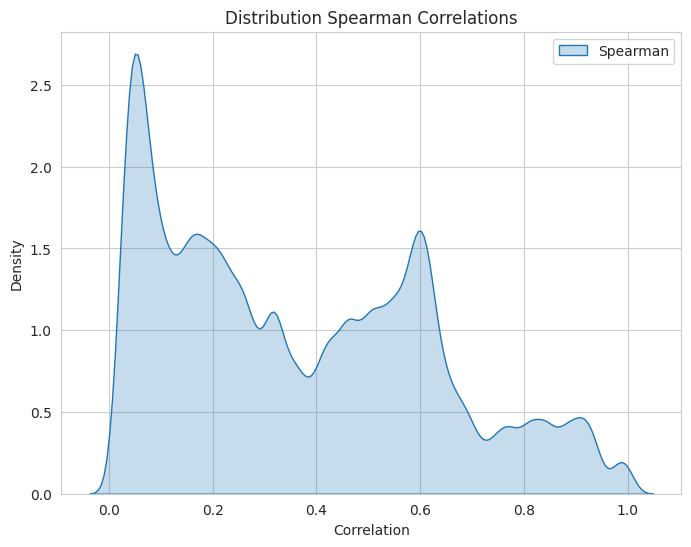

In [25]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
# sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution Spearman Correlations")
plt.legend()
plt.show()